# Figure 4: disorders

## Setup

In [2]:
# Set working directory
%cd work/notebooks
# Autoreload
%load_ext autoreload
%autoreload 2
# Use rpy2 to run R in python notebook for plotting
%load_ext rpy2.ipython

/home/jovyan/work/notebooks


In [8]:
# Import local code
import sys
sys.path.append('/home/jovyan/work/code')
from gradientVersion import *
from processing import *
from analysis_helpers import *
from disorders_data import *
from disorders import *
# Need enrichment test and spin test functions 
from enrichments import *
from maps_null_test import *

### Compute components

In [ ]:
dme_3d_ds5 = gradientVersion(approach='dm', kernel='normalized_angle', alpha=1).fit('hcp_3d_ds5')

New gradients version: method=pca, kernel=None, sparsity=0, data=hcp_base
New gradients version: method=dm, kernel=normalized_angle, sparsity=0, data=hcp_3d_ds5


---

## Disorder imaging

### Brainchart disorder maps

In [87]:
brainchart_maps = get_disorder_maps().loc[:,['ASD','MDD','SCZ']].apply(lambda x: (x-np.mean(x))/np.std(x)) * -1
# brainchart_maps_plot = brainchart_maps.apply(lambda x: (x-np.mean(x))/np.std(x))

In [88]:
brainchart_maps.describe()

,ASD,MDD,SCZ
count,3.400000e+01,3.400000e+01,3.400000e+01
mean,-9.632817e-17,-6.040919e-16,3.526591e-16
std,1.015038e+00,1.015038e+00,1.015038e+00
min,-2.391059e+00,-2.660308e+00,-2.455864e+00
25%,-5.924749e-01,-3.890258e-01,-6.971452e-01
50%,7.161784e-02,1.178866e-02,7.174201e-02
75%,5.281816e-01,5.462080e-01,6.285224e-01
max,1.870202e+00,2.149466e+00,1.750921e+00


In [89]:
dk_scores = dme_3d_ds5.score_in_dk()
# dk_scores = dm_ds8.score_in_dk()

In [90]:
brainchart_maps_and_scores = pd.concat([brainchart_maps,dk_scores.set_index('label')], axis=1)

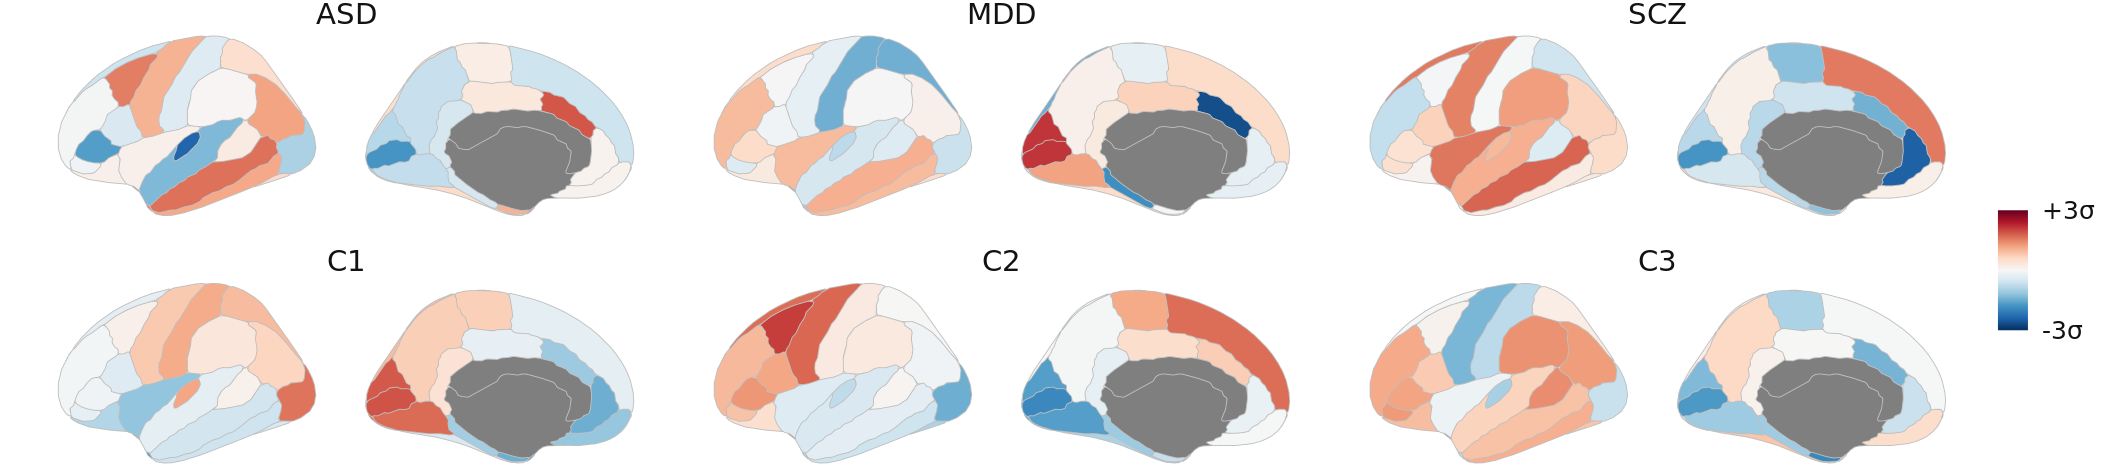

In [91]:
%%R -w 180 -h 40 -u mm -r 300 -i brainchart_maps_and_scores
source("../code/fig4_plots.R")
g_brainchart <- plot_brains(brainchart_maps_and_scores, ncol=3)
g_brainchart

### Brainchart disorder heatmap

In [92]:
dk_nulls = np.load(f"../outputs/permutations/spin_dk_5000_dm_hcp_3d_ds5_vertices.npy")

In [93]:
corrs = brainchart_maps_and_scores.corr().iloc[:3,3:]
brainchart_null_p = corr_nulls_from_grads(dk_nulls, dk_scores, brainchart_maps, method='pearsonr', reindex=False)
brainchart_null_p

,C,map,r,p,q
0,C1,ASD,-0.473220,0.000200,0.001800
1,C1,MDD,0.284355,0.135773,0.305489
2,C1,SCZ,-0.003674,0.991002,0.991002
3,C2,ASD,0.274723,0.000800,0.003599
4,C2,MDD,-0.216506,0.239952,0.431914
5,C2,SCZ,0.239524,0.581484,0.747622
6,C3,ASD,0.084667,0.735053,0.826935
7,C3,MDD,0.124185,0.555889,0.747622
8,C3,SCZ,0.433096,0.008198,0.024595


## Disorder enrichments

### GWAS & DEGs

In [98]:
# weights = dme_ibf0_3d_ds6.weights
# null_weights = shuffle_gene_weights(weights, n=5000)
weights = dme_3d_ds5.weights
null_weights = shuffle_gene_weights(weights, n=5000)

In [95]:
gwas_genes = get_gwas_combined() #.loc[lambda x: x['label']!='MDD']
gwas_stats = compute_null_p(*compute_enrichments(weights, null_weights, gwas_genes), adjust_by_label=True)
gwas_stats

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,ASD,C1,0.9876,0.140450,-0.034575,0.077924,2.246101,True,0.0248,0.0372,True,235,56
1,ASD,C2,0.0100,-0.071455,0.027419,0.041182,-2.400899,False,0.0200,0.0372,True,235,56
2,ASD,C3,0.6672,0.022389,0.007376,0.034351,0.437047,True,0.6656,0.6656,False,235,56
3,MDD,C1,0.9364,0.045152,-0.032634,0.051877,1.499426,True,0.1272,0.1908,False,269,130
4,MDD,C2,0.0430,-0.021020,0.026634,0.027685,-1.721302,False,0.0860,0.1908,False,269,130
5,MDD,C3,0.8002,0.025380,0.006420,0.022447,0.844653,True,0.3996,0.3996,False,269,130
6,SCZ,C1,0.9792,0.049494,-0.032719,0.039976,2.056577,True,0.0416,0.0624,False,562,212
7,SCZ,C2,0.0438,-0.009462,0.027072,0.021253,-1.719028,False,0.0876,0.0876,False,562,212
8,SCZ,C3,0.9980,0.057389,0.006975,0.017811,2.830543,True,0.0040,0.0120,True,562,212


In [214]:
gwas_genes.groupby('label').count()

,gene
label,
ASD,235
MDD,269
SCZ,562


In [127]:
# pd.read_csv("../data/deg/girgenti2021_tableS9.csv", header=0, usecols=['Genename','MDD.dlPFC.log2FoldChange','MDD.dlPFC.padj']).loc[lambda x: x['MDD.dlPFC.padj']<=0.05, ['Genename','MDD.dlPFC.log2FoldChange']]
get_deg_consensus().query("label=='MDD'")

,label,gene,study
4949,MDD,ARRDC3,2
5019,MDD,CRYM,2
5029,MDD,CYBB,2
5098,MDD,GJD2,2
5118,MDD,HMGB2,2
5156,MDD,KCNJ16,2
5170,MDD,LGI2,2
5306,MDD,RGS10,2
5372,MDD,ST8SIA4,2
5443,MDD,ZNF442,2


In [212]:
deg_genes = get_deg_consensus()
deg_stats = compute_null_p(*compute_enrichments(weights, null_weights, deg_genes))
deg_stats

,label,C,pct,true_mean,null_mean,null_std,z,pos,p,q,sig,n_genes,n_matches
0,ASD,C1,1.0000,0.065250,-0.032496,0.019381,5.043488,True,0.0000,0.000000,True,1456,824
1,ASD,C2,1.0000,0.078122,0.026696,0.010484,4.905116,True,0.0000,0.000000,True,1456,824
2,ASD,C3,0.2894,0.001762,0.006564,0.008583,-0.559389,False,0.5788,0.744171,False,1456,824
3,MDD,C1,0.0030,-0.199171,-0.033034,0.059987,-2.769551,False,0.0060,0.018000,True,182,92
4,MDD,C2,0.7160,0.045437,0.026938,0.032559,0.568168,True,0.5680,0.744171,False,182,92
5,MDD,C3,0.0674,-0.034594,0.006016,0.026665,-1.522968,False,0.1348,0.242640,False,182,92
6,SCZ,C1,0.3976,-0.040592,-0.032711,0.031187,-0.252680,False,0.7952,0.894600,False,506,336
7,SCZ,C2,0.5318,0.027969,0.026872,0.016998,0.064539,True,0.9364,0.936400,False,506,336
8,SCZ,C3,0.9936,0.041190,0.006911,0.013678,2.506190,True,0.0128,0.028800,True,506,336


In [213]:
deg_genes.groupby('label').count()

,gene,study
label,,
ASD,1456,1456
MDD,182,182
SCZ,506,506


### Heatmaps plot

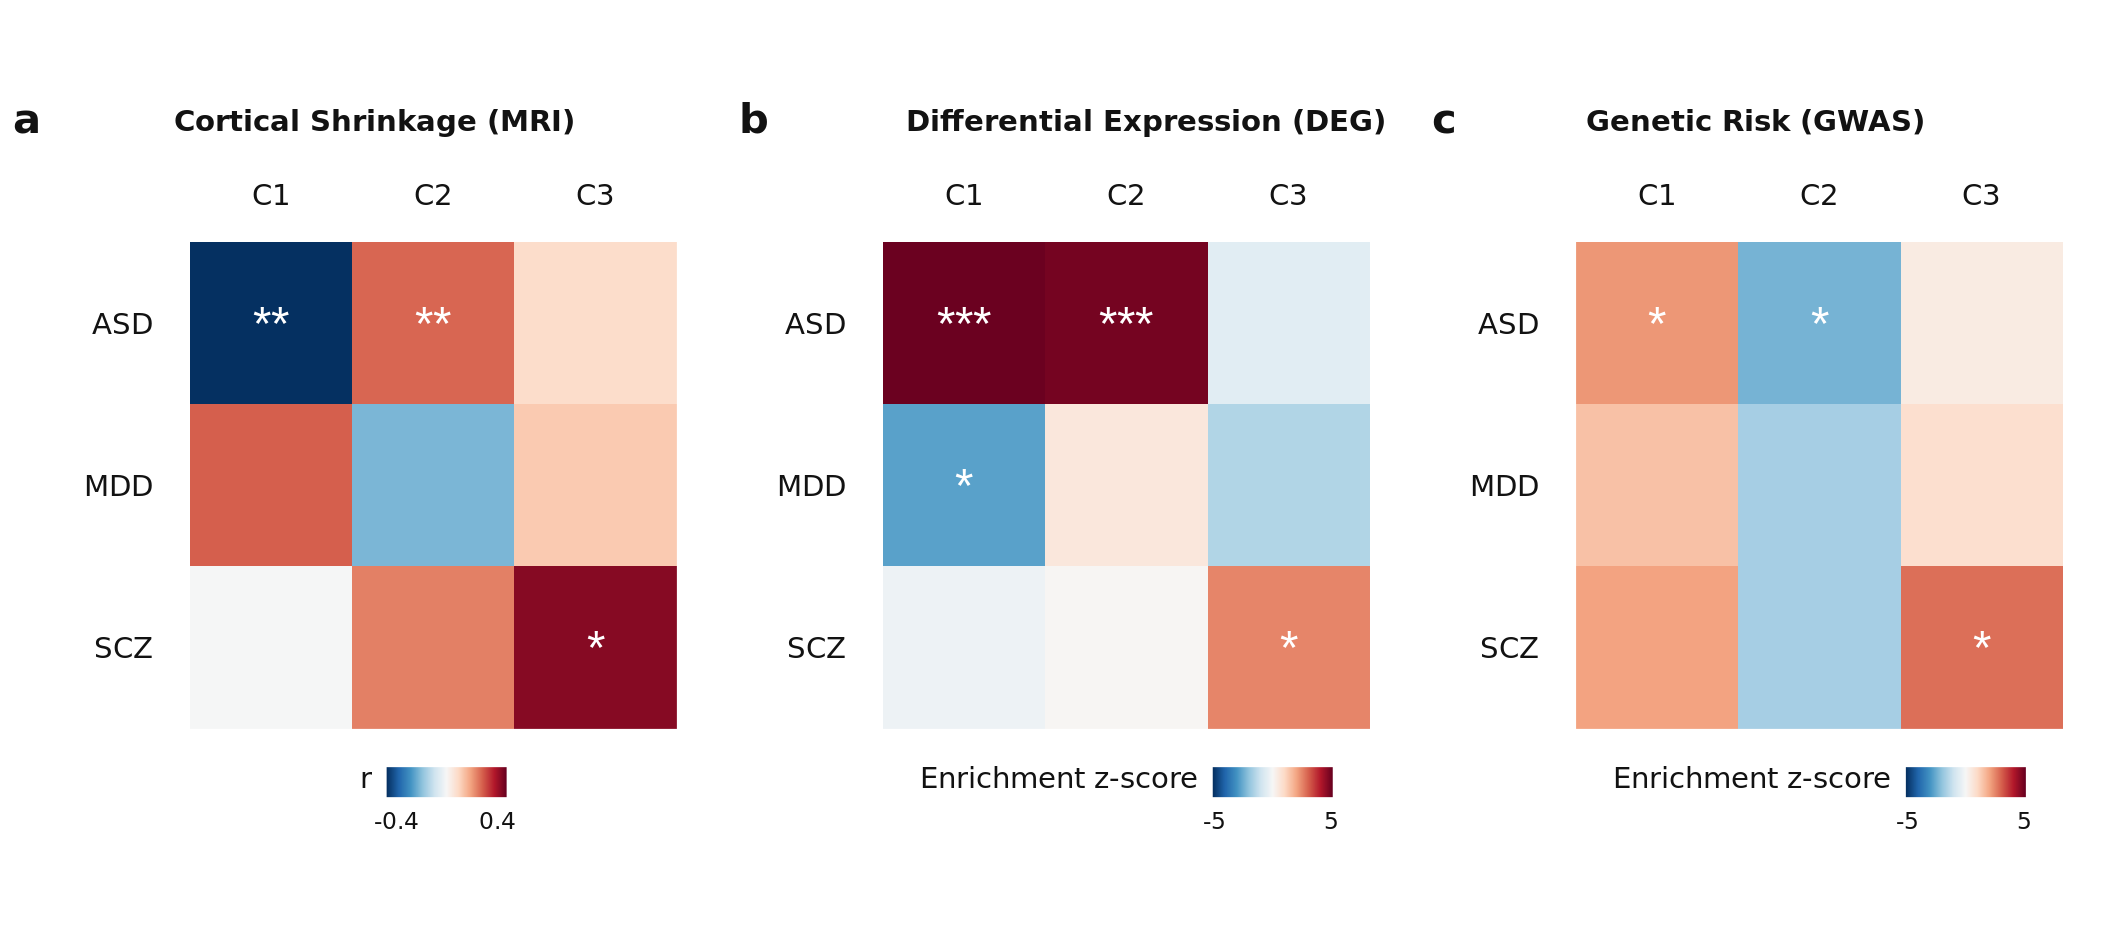

In [100]:
%%R -w 180 -h 80 -u mm -r 300 -i brainchart_null_p -i deg_stats -i gwas_stats
source("../code/fig4_plots.R")

g1 <- plot_heatmap_maps(brainchart_null_p) + ggtitle('Cortical Shrinkage (MRI)') +
    theme(plot.tag.position = c(-0.05, .99), plot.title=element_text(hjust=0, margin=margin(0,0,.2,0,'mm')))
g2 <- plot_heatmap_enrichments(deg_stats, limits=5.1) + ggtitle('Differential Expression (DEG)') +
    theme(plot.tag.position = c(0, .99), plot.title=element_text(hjust=1, margin=margin(0,0,.2,0,'mm')))
g3 <- plot_heatmap_enrichments(gwas_stats, limits=5.1) + ggtitle('Genetic Risk (GWAS)') +
    theme(plot.tag.position = c(0, .99), plot.title=element_text(hjust=0.5, margin=margin(0,0,.2,0,'mm')))

g_heatmaps <- (g1 + g2 + g3) & theme(legend.margin = margin(t=-2, r=0, b=0, l=0, "mm"))

g_heatmaps + plot_annotation(tag_level='a')

### SCZ supragranular

In [384]:
scz_diff = get_scz_gyral_sulcal(name='SCZ Supra-granular (L2/L3) Thinning')
scz_diff_brain = scz_diff.join(dme_3d_ds5.clean_scores().set_index('label')['C3'])

scores_melt = dme_3d_ds5.clean_scores().set_index('label').melt(ignore_index=False)
scz_diff_scatter = (scz_diff
                    .join(scores_melt)
                    .set_axis(['map_score','C','C_score'], axis=1)
                    .assign(map = 'SCZ Supra-granular (L2/L3) Thinning')
                    )
scz_diff_scatter

,map_score,C,C_score,map
label,,,,
1,-0.712678,C1,1.459701,SCZ Supra-granular (L2/L3) Thinning
1,-0.712678,C2,0.540351,SCZ Supra-granular (L2/L3) Thinning
1,-0.712678,C3,-0.947158,SCZ Supra-granular (L2/L3) Thinning
10d,-0.500203,NaN,NaN,SCZ Supra-granular (L2/L3) Thinning
10pp,-0.589750,NaN,NaN,SCZ Supra-granular (L2/L3) Thinning
...,...,...,...,...
s32,-0.856272,C1,-1.406160,SCZ Supra-granular (L2/L3) Thinning
s32,-0.856272,C2,-0.402114,SCZ Supra-granular (L2/L3) Thinning
s32,-0.856272,C3,-0.076845,SCZ Supra-granular (L2/L3) Thinning


In [385]:
hcp_scores = dme_3d_ds5.clean_scores()
nulls = np.load('../outputs/permutations/dme_3d_ds5_clean_spin_41k_5000.npy')
null_corrs = corr_nulls_from_grads(nulls, hcp_scores, scz_diff)
scz_diff_corrs = null_corrs.reset_index().rename({'level_0':'C', 'level_1':'map'}, axis=1)
scz_diff_corrs

,index,C,map,r,p,q
0,0,C1,SCZ Supra-granular (L2/L3) Thinning,0.130798,0.760248,0.760248
1,1,C2,SCZ Supra-granular (L2/L3) Thinning,-0.151286,0.752849,0.760248
2,2,C3,SCZ Supra-granular (L2/L3) Thinning,0.551487,0.002400,0.007199


`geom_smooth()` using formula = 'y ~ x'


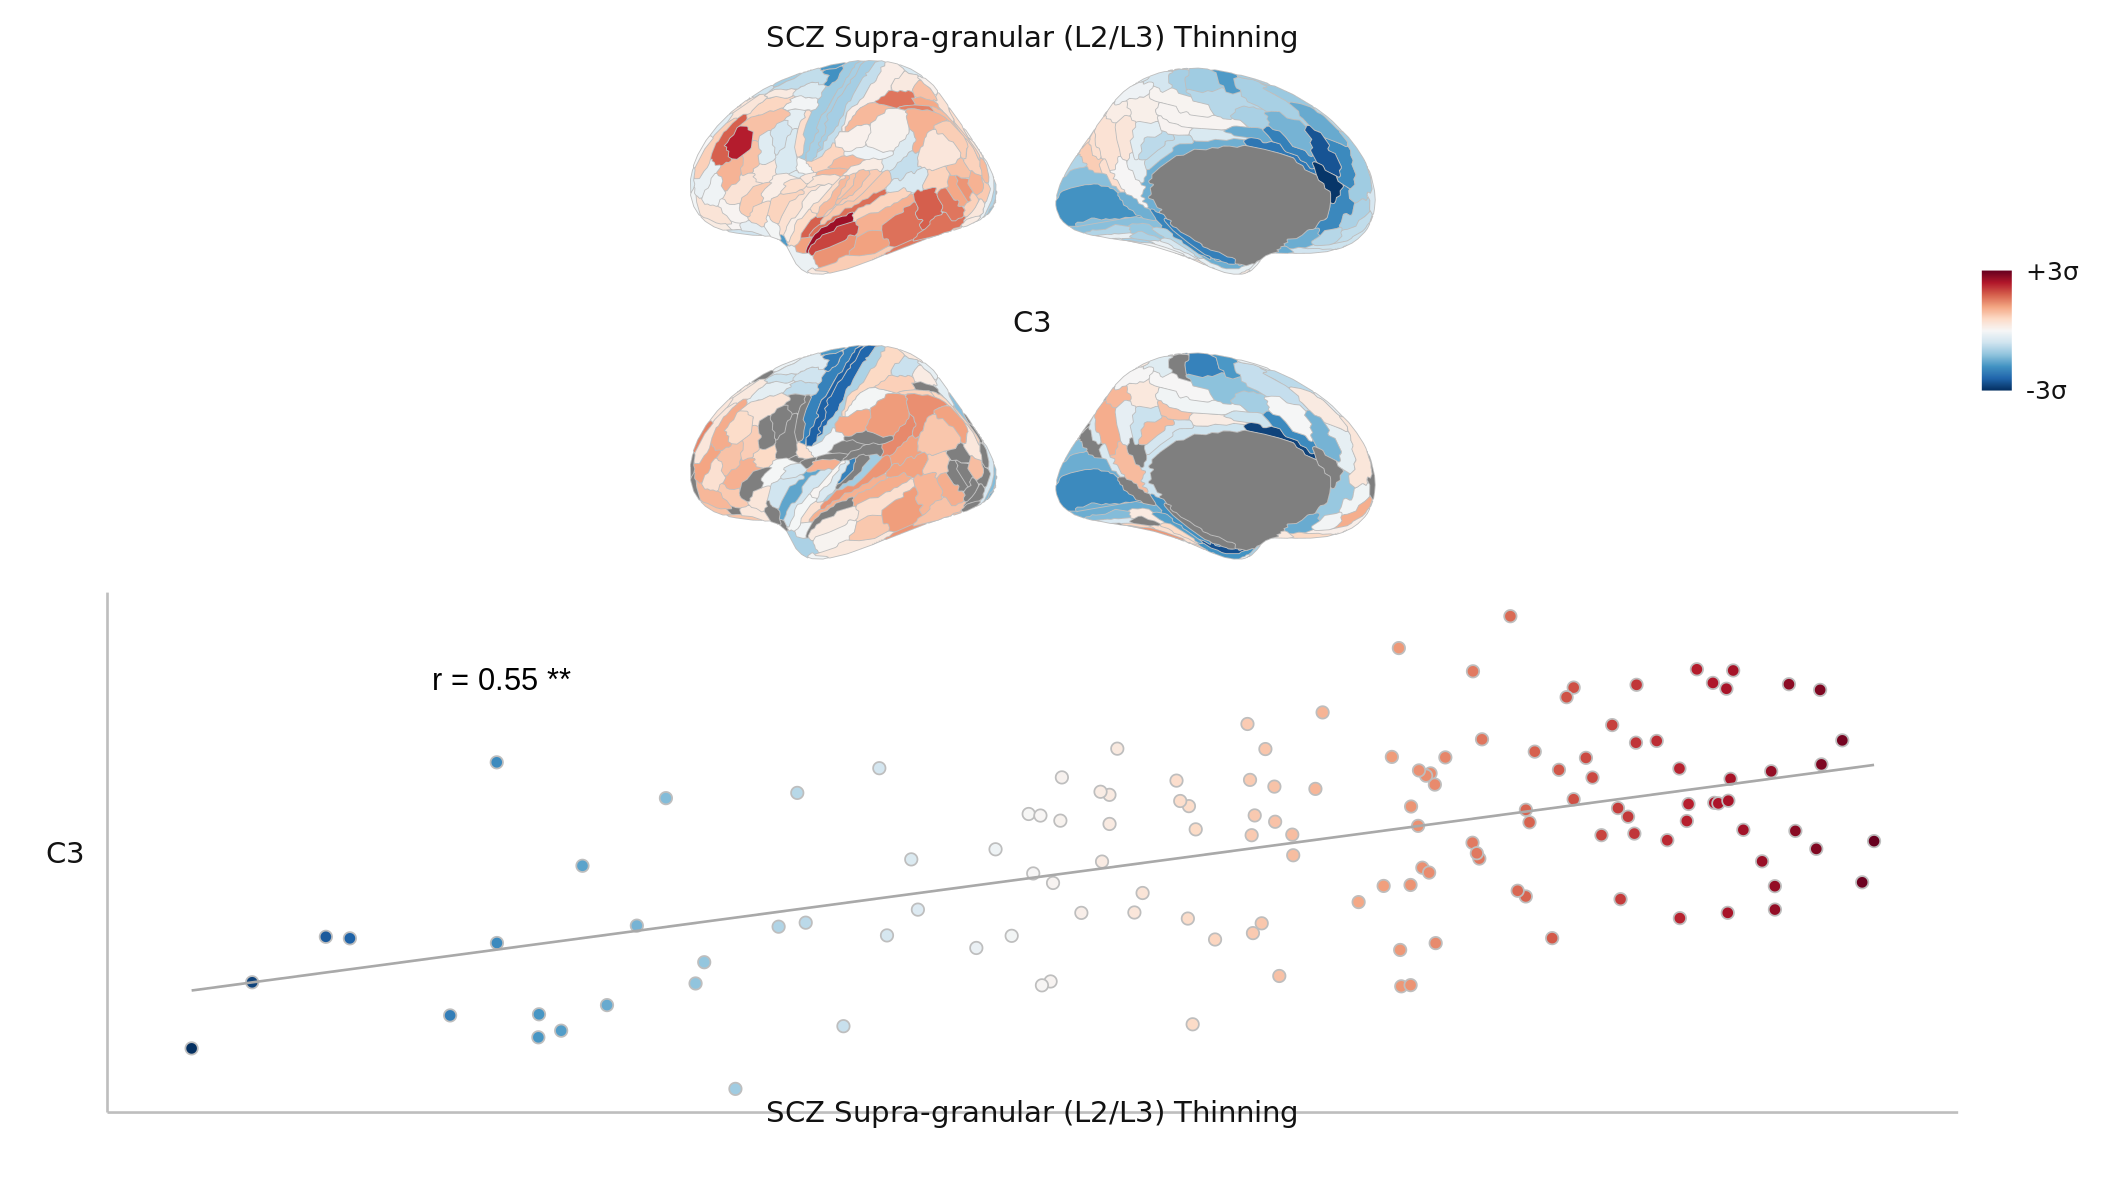

In [403]:
%%R -w 180 -h 100 -u mm -r 300 -i scz_diff_brain -i hcp_scores -i scz_diff_scatter -i scz_diff_corrs
source("../code/fig4_plots.R")

plot_scz_brain <- plot_brains(scz_diff_brain, atlas='glasser', ncol=1) + 
                  guides(fill=guide_colorbar(barwidth=.5, barheight=2, ticks=FALSE, title.vjust=1))
plot_scz_scatter <- plot_maps_scatter(
                scz_diff_scatter %>% filter(C=='C3'), 
                scz_diff_corrs   %>% filter(C=='C3'),
                y=1.7, x=-2, switch='both', 
                xlab = 'SCZ Supra-granular (L2/L3) Thinning',
                ylab = 'C3') + plot_layout(tag_level='new')

# g2d = plot_map_corrs(scz_diff_corrs, size=10) + theme(axis.text.y=element_blank()) + plot_layout(tag_level='new')

g_scz <- plot_scz_brain / plot_scz_scatter 
g_scz

### Venn

In [105]:
overlap_deg_gwas = pd.concat({
    'GWAS': gwas_genes,
    'DEG': deg_genes.drop('study',axis=1)
}).reset_index(0).rename({'label':'disorder','level_0':'label'}, axis=1).reset_index(drop=True)

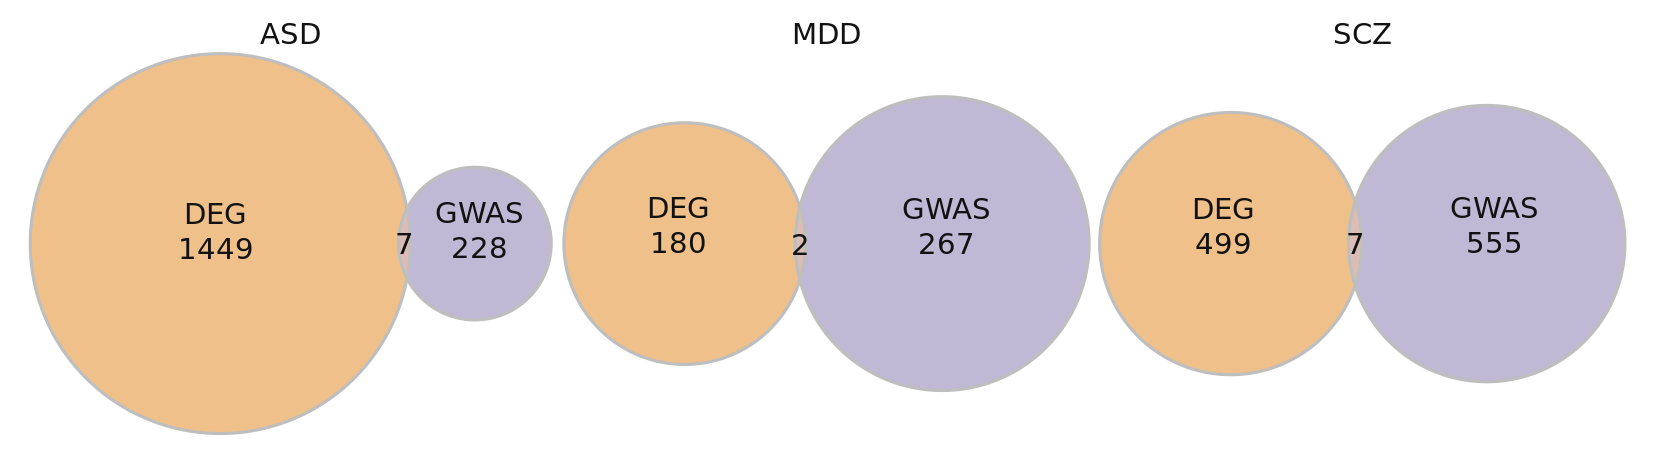

In [108]:
%%R -i overlap_deg_gwas -w 140 -h 40 -u mm -r 300
source("../code/fig4_plots.R")
g_overlaps <-  plot_venn(overlap_deg_gwas, disorder='ASD') + 
            (plot_venn(overlap_deg_gwas, disorder='MDD') + plot_layout(tag_level='new')) +
            (plot_venn(overlap_deg_gwas, disorder='SCZ') + plot_layout(tag_level='new'))

g_overlaps

### C3 positive layers and devt

In [109]:
C3_positive = weights.loc[lambda x: x['C3']>0, :].index
C3_negative = weights.loc[lambda x: x['C3']<0, :].index

layer_enrichments_C3positive = test_layers_all_combinations(
    background = weights.index, 
    disorder_genes = overlap_deg_gwas, 
    layer_genes = get_layer_genes(add_hse_genes=False),
    reference_filter = C3_positive
)
layer_enrichments_C3negative = test_layers_all_combinations(
    background = weights.index, 
    disorder_genes = overlap_deg_gwas, 
    layer_genes = get_layer_genes(add_hse_genes=False),
    reference_filter = C3_negative
)
layer_enrichments_C3positive.head()

Done GWAS-ASD.
Done DEG-ASD.
Done GWAS-MDD.
Done DEG-MDD.
Done GWAS-SCZ.
Done DEG-SCZ.
Done GWAS-ASD.
Done DEG-ASD.
Done GWAS-MDD.
Done DEG-MDD.
Done GWAS-SCZ.
Done DEG-SCZ.


,label,disorder,layer,n,N,pct,odds_ratio,p,q,sig
0,GWAS,ASD,L1,1,28,0.035714,0.421311,0.905444,1.000000,False
1,GWAS,ASD,L2,4,28,0.142857,1.769250,0.218581,0.459020,False
2,GWAS,ASD,L3,1,28,0.035714,3.466049,0.259643,0.519285,False
3,GWAS,ASD,L4,2,28,0.071429,2.688479,0.183866,0.406440,False
4,GWAS,ASD,L5,1,28,0.035714,0.912186,0.672408,0.973833,False


In [111]:
layer_enrichments_all = test_layers_all_combinations(
    background = weights.index, 
    disorder_genes = overlap_deg_gwas, 
    layer_genes = get_layer_genes(add_hse_genes=False),
    reference_filter = None
)
layer_enrichments_all

Done GWAS-ASD.
Done DEG-ASD.
Done GWAS-MDD.
Done DEG-MDD.
Done GWAS-SCZ.


KeyboardInterrupt: 

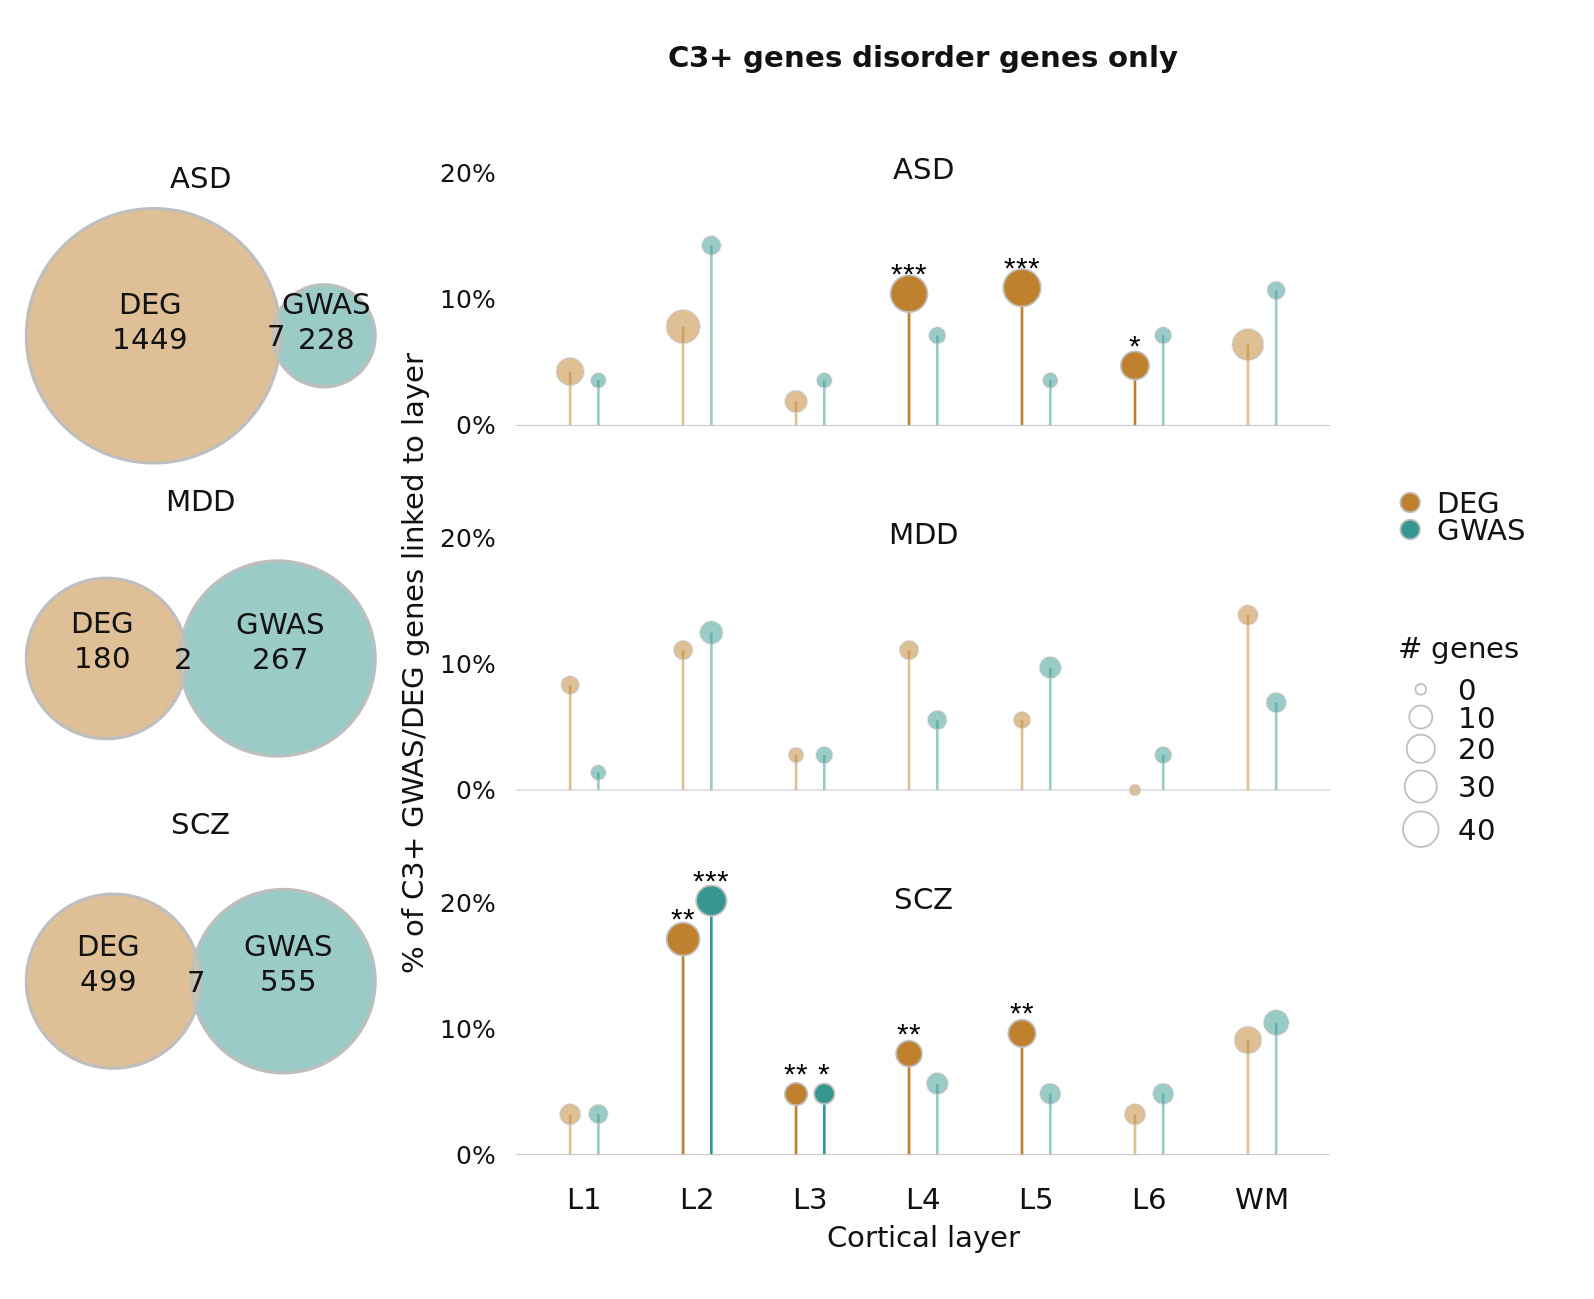

In [119]:
%%R -w 135 -h 110 -u mm -r 300 -i layer_enrichments_C3positive -i overlap_deg_gwas
source("../code/fig4_plots.R")

g_overlaps <-    plot_venn(overlap_deg_gwas, disorder='ASD') + 
                (plot_venn(overlap_deg_gwas, disorder='MDD') + plot_layout(tag_level='new')) +
                (plot_venn(overlap_deg_gwas, disorder='SCZ') + plot_layout(tag_level='new')) + plot_layout(ncol=1)

g_layers <- layer_enrichments_C3positive %>% plot_disorder_layer_enrichments + ggtitle('C3+ genes disorder genes only')

layout <- c(
    area(t=2,b=36,l=1,r=35),
    area(t=37,b=71,l=1,r=35),
    area(t=72,b=106,l=1,r=35),
    area(t=1,b=110,l=36,r=115)
)

(g_overlaps) + g_layers + plot_layout(design=layout)

## Combined disorders fig

`geom_smooth()` using formula = 'y ~ x'


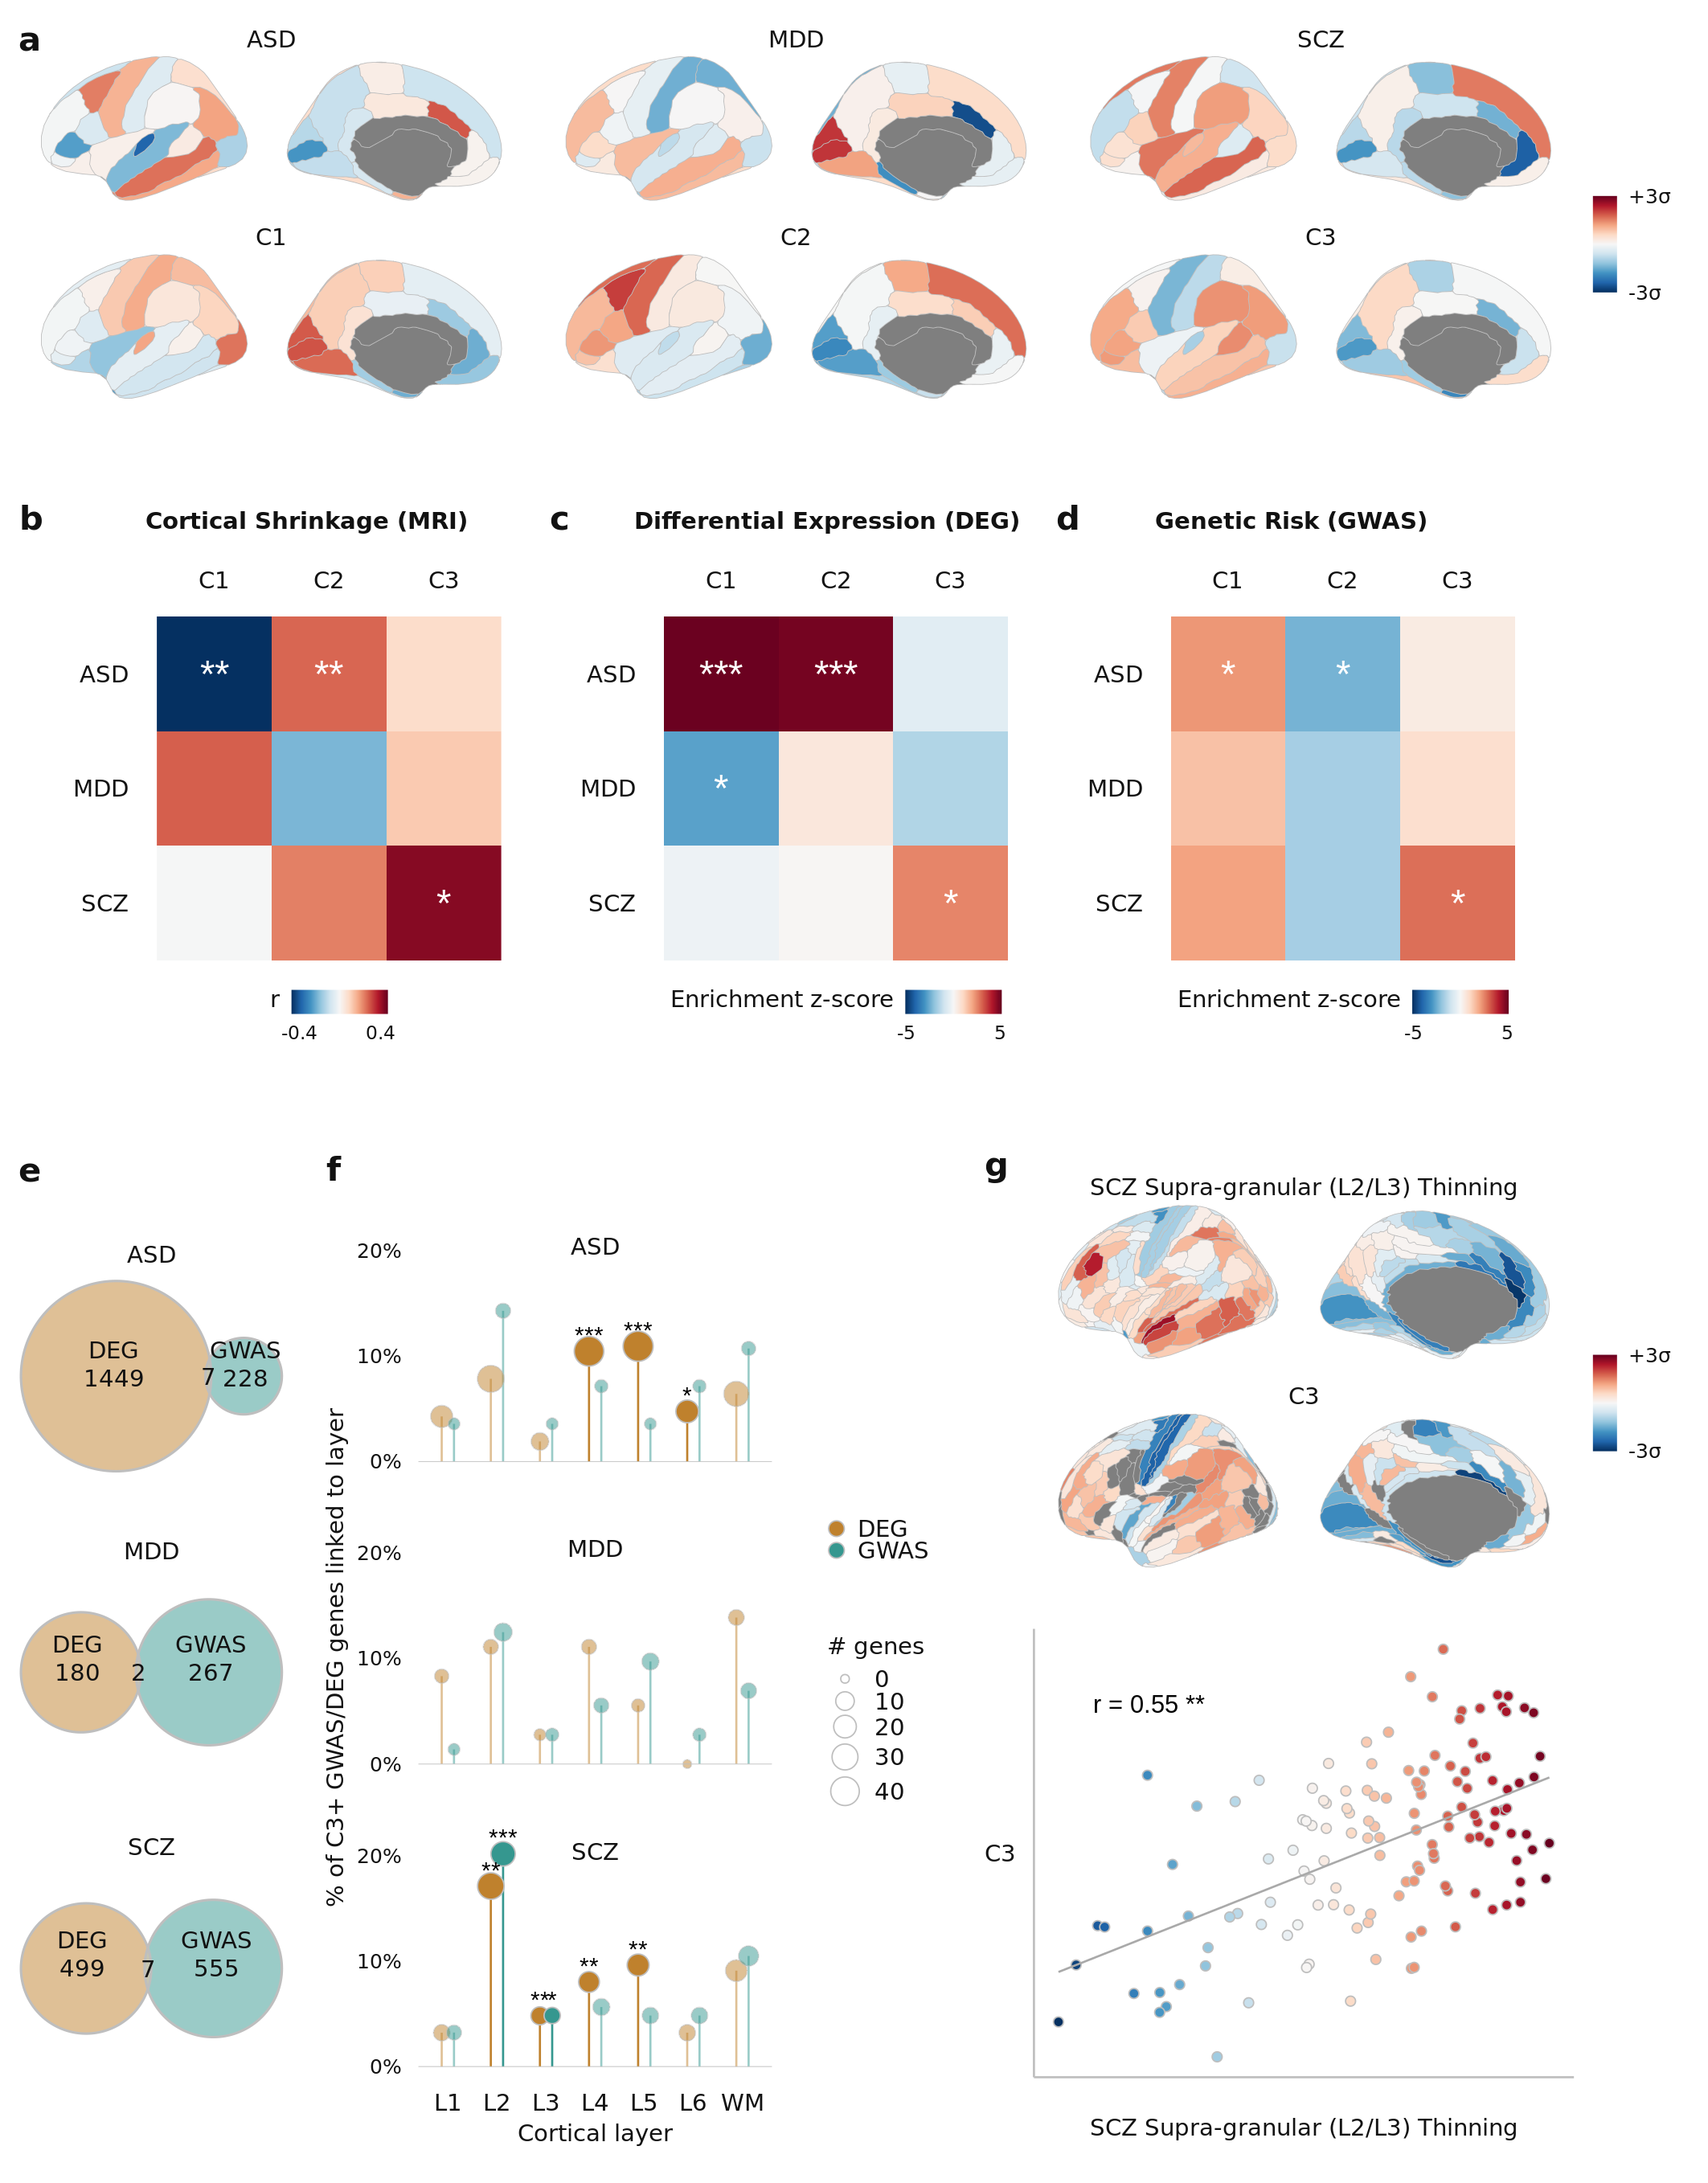

In [408]:
%%R -w 180 -h 230 -u mm -r 300 -i layer_enrichments_C3positive -i overlap_deg_gwas
source("../code/fig4_plots.R")

g_overlaps <-    plot_venn(overlap_deg_gwas, disorder='ASD', bottom_margin=6) + 
                (plot_venn(overlap_deg_gwas, disorder='MDD', bottom_margin=6) + plot_layout(tag_level='new')) +
                (plot_venn(overlap_deg_gwas, disorder='SCZ', bottom_margin=0) + plot_layout(tag_level='new')) + plot_layout(ncol=1)
g_overlaps <- g_overlaps & theme(plot.tag.position=c(0,1.32))
g_layers_pos <- layer_enrichments_C3positive %>% plot_disorder_layer_enrichments(ncol=1) + 
                theme(plot.tag.position=c(0,1.02))

layout <- c(
    area(t=1,b=50,l=1,r=180),
    area(t=56,b=115,l=2,r=175),
    area(t=123,b=230,l=1,r=25),
    area(t=122,b=230,l=30,r=90),
    area(t=121,b=230,l=91,r=180)
)

plot <- g_brainchart + g_heatmaps + g_overlaps + g_layers_pos + g_scz + plot_layout(design=layout)
plot + plot_annotation(tag_level='a')